# Predicting-House-Prices-in-King-County 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import datetime

In [2]:
df = pd.read_csv('kc_house.csv')
print(df.head())
print(df.info())

      price  bedrooms  bathrooms  sqft_living  landsize  floors  waterfront  \
0  221900.0         3          1         1180      5650       1           0   
1  538000.0         3          2         2570      7242       2           0   
2  180000.0         2          1          770     10000       1           0   
3  604000.0         4          3         1960      5000       1           0   
4  510000.0         3          2         1680      8080       1           0   

   view  condition  grade  yr_built  yr_renovated  zipcode  sqft_living15  \
0     0          3      7      1955             0    98178           1340   
1     0          3      7      1951          1991    98125           1690   
2     0          3      6      1933             0    98028           2720   
3     0          5      7      1965             0    98136           1360   
4     0          3      8      1987             0    98074           1800   

   landsize15  Year  Month  Day  
0        5650  2014     10  

In [3]:
# Preprocess data: Handle missing values if any, convert date to datetime
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

In [4]:
df['yr_renovated'] = np.where(df['yr_renovated'] > 0, df['yr_renovated'], df['yr_built'])

In [5]:
df = df.drop(['Year', 'Month', 'Day'], axis=1)  # Drop separate date columns

In [6]:
# Features and target for general use
features = ['bedrooms', 'bathrooms', 'sqft_living', 'landsize', 'floors', 'waterfront', 'view', 'condition', 'grade',
            'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'landsize15']
target = 'price'

In [7]:
# House Price Prediction (Regression)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [9]:
predictions = model1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE for Price Prediction: {rmse}')

RMSE for Price Prediction: 179799.91588253758


In [10]:
# Renovation Impact Analysis (Regression on value added)
df['renovated'] = df['yr_renovated'] != df['yr_built']
df['years_since_renovation'] = df['date'].dt.year - df['yr_renovated']
X_renov = df[['renovated', 'years_since_renovation'] + features]

In [11]:
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression()

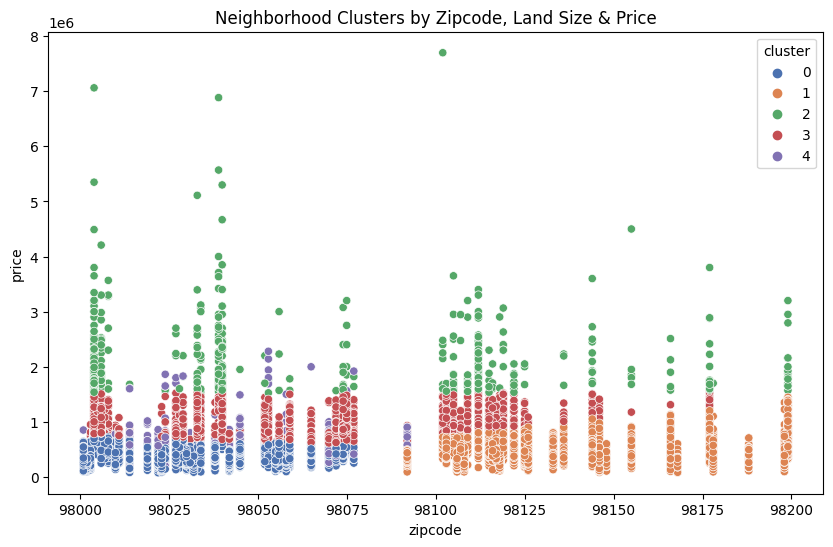

In [12]:
# Neighborhood Price Clustering
cluster_features = ['zipcode', 'landsize', 'price']
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[cluster_features])
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='zipcode', y='price', hue='cluster', data=df, palette='deep')
plt.title("Neighborhood Clusters by Zipcode, Land Size & Price")
plt.show()

In [13]:
# Outlier Detection (Anomaly Detection)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(X)
df['outlier'] = outliers
print("Outlier Distribution:")
print(df['outlier'].value_counts())

Outlier Distribution:
outlier
 1    21396
-1      217
Name: count, dtype: int64


In [14]:
# Aggregate and prepare time series
ts_df = df.groupby('date')['price'].mean().reset_index()
ts_df = ts_df.set_index('date').sort_index()

In [15]:
# 7-day rolling average
ts_df['price_7d_avg'] = ts_df['price'].rolling(window=7, min_periods=1).mean()

In [16]:
# Drop NaN (from rolling)
ts_df = ts_df.dropna(subset=['price'])

In [17]:
# Create numeric time index
ts_df['days_since_start'] = (ts_df.index - ts_df.index.min()).days

In [18]:
# Train model using DataFrame
X_trend = ts_df[['days_since_start']]  # Keep as DataFrame
y_trend = ts_df['price']
trend_model = LinearRegression()
trend_model.fit(X_trend, y_trend)

LinearRegression()

In [19]:
# Forecast: Use DataFrame for prediction too!
last_date = ts_df.index.max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({
    'days_since_start': (future_dates - ts_df.index.min()).days
})
forecast = trend_model.predict(future_df)

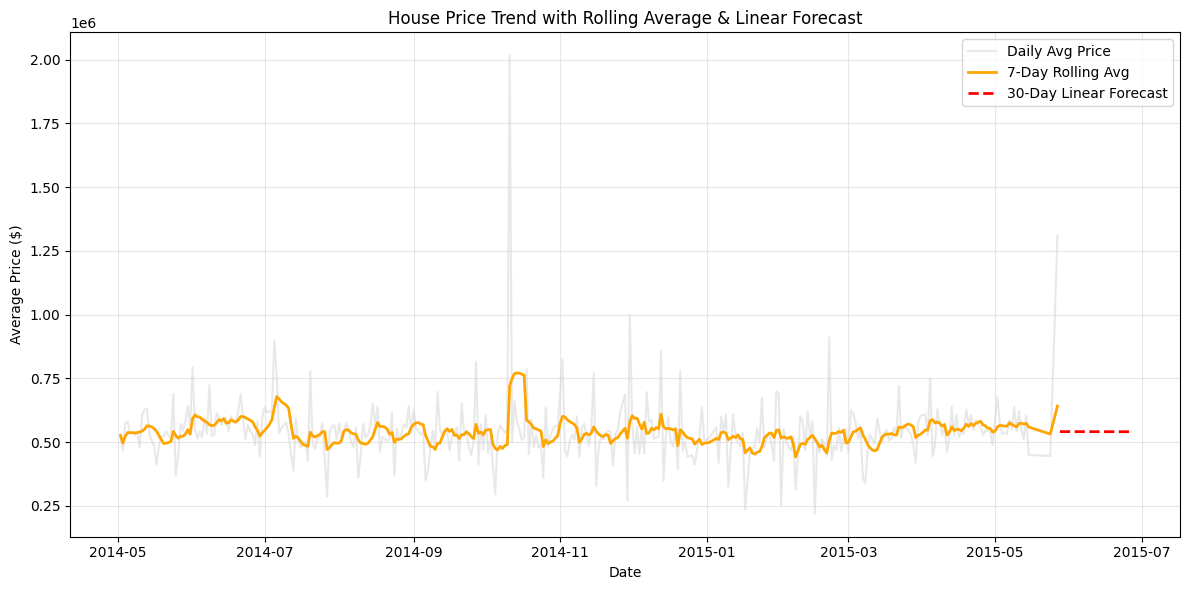

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['price'], label='Daily Avg Price', alpha=0.5, color='lightgray')
plt.plot(ts_df.index, ts_df['price_7d_avg'], label='7-Day Rolling Avg', color='orange', linewidth=2)
plt.plot(future_dates, forecast, label='30-Day Linear Forecast', color='red', linestyle='--', linewidth=2)
plt.title('House Price Trend with Rolling Average & Linear Forecast')
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
slope = trend_model.coef_[0]
print(f"Daily price trend: ${slope:,.2f} per day")
print(f"30-day forecast range: ${forecast.min():,.0f} – ${forecast.max():,.0f}")

Daily price trend: $-13.91 per day
30-day forecast range: $540,869 – $541,273


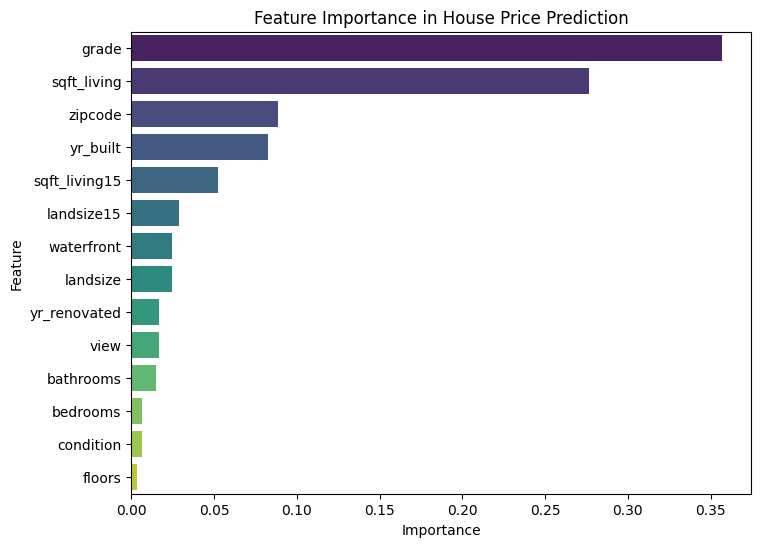

In [22]:
# Feature Importance for Buyer Preferences
importances = model1.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})\
    .sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("Feature Importance in House Price Prediction")
plt.show()

In [23]:
# House Grade Classification (Classification)
target_grade = 'grade'
X_grade = df.drop([target, target_grade, 'date'], axis=1)
y_grade = df[target_grade]
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_grade, y_grade, test_size=0.2, random_state=42)

In [24]:
model7 = DecisionTreeClassifier(max_depth=10, random_state=42)
model7.fit(X_train_g, y_train_g)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [25]:
acc = accuracy_score(y_test_g, model7.predict(X_test_g))
print(f'Accuracy for Grade Classification: {acc:.4f}')

Accuracy for Grade Classification: 0.6225


In [26]:
# Similar House Recommendation (KNN)
nn = NearestNeighbors(n_neighbors=6, metric='euclidean') 
nn.fit(X)
example_idx = 0
distances, indices = nn.kneighbors(X.iloc[[example_idx]])
print(f"Top 5 similar houses to House #{example_idx}:")
print(df.iloc[indices[0][1:]].round(2)[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'zipcode']])

Top 5 similar houses to House #0:
          price  bedrooms  bathrooms  sqft_living  zipcode
19546  515000.0         2          1         1150    98115
15249  345000.0         3          1         1060    98146
5809   258000.0         3          1         1040    98178
6666   463000.0         2          1         1250    98126
18927  374000.0         2          1         1140    98116


In [27]:
# Waterfront Property Valuation (Specialized Regression)
waterfront_df = df[df['waterfront'] == 1].copy()
if len(waterfront_df) > 10:
    X_w = waterfront_df[features]
    y_w = waterfront_df[target]
    model9 = RandomForestRegressor(n_estimators=100, random_state=42)
    model9.fit(X_w, y_w)
    print(f"Waterfront model trained on {len(waterfront_df)} properties.")
else:
    print("Not enough waterfront properties to train a model.")

Waterfront model trained on 163 properties.


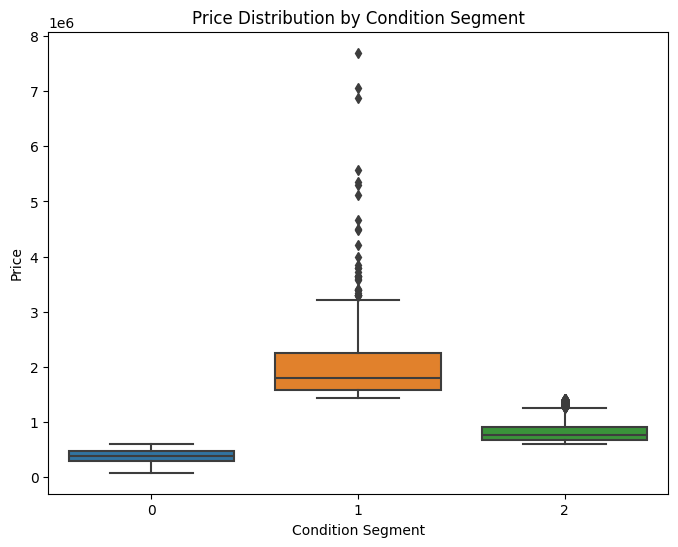

In [28]:
# Market Segmentation by Condition (Clustering)
cond_features = ['condition', 'price']
X_cond = df[cond_features]
kmeans_cond = KMeans(n_clusters=3, random_state=42)
df['cond_segment'] = kmeans_cond.fit_predict(X_cond)

plt.figure(figsize=(8, 6))
sns.boxplot(x='cond_segment', y='price', data=df)
plt.title("Price Distribution by Condition Segment")
plt.xlabel("Condition Segment")
plt.ylabel("Price")
plt.show()

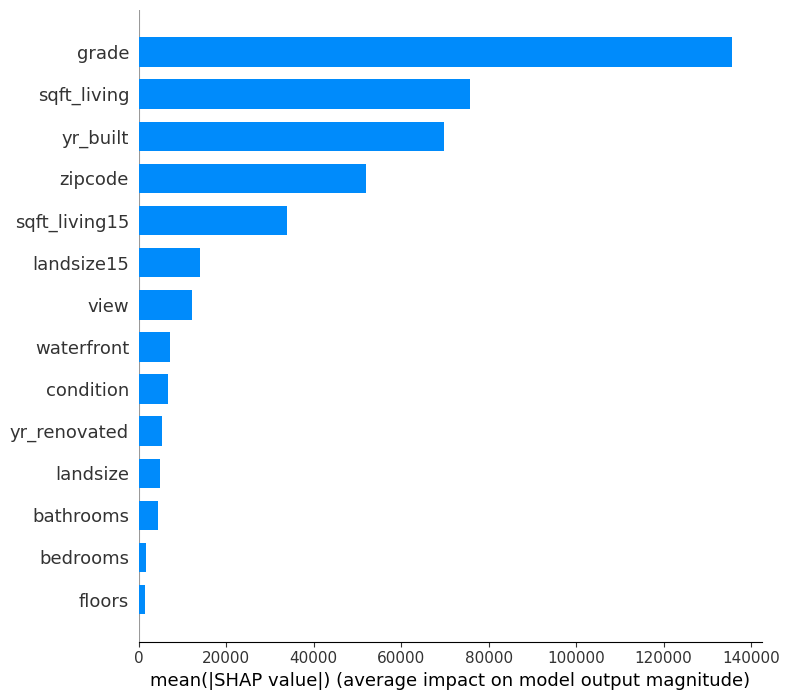

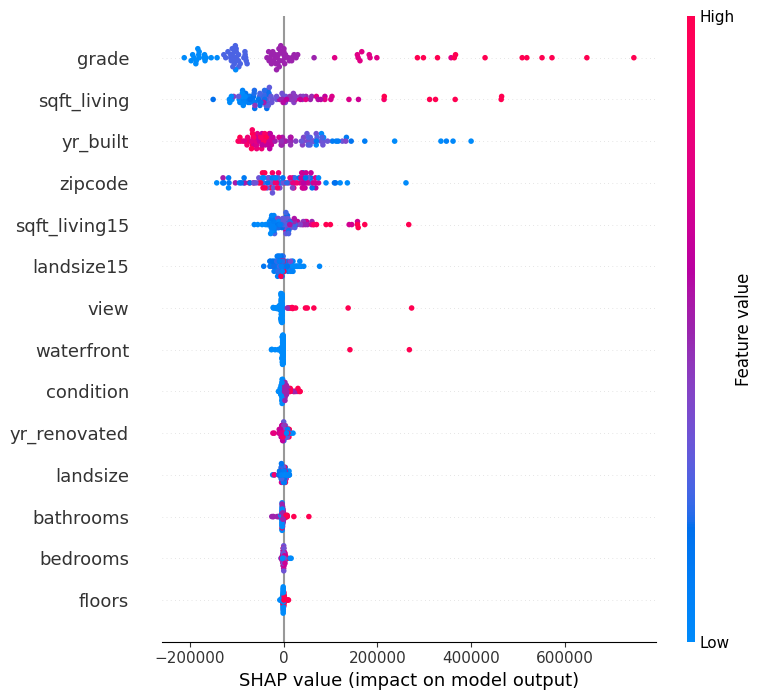

In [29]:
# SHAP Explanations (For Model 1 - Price Prediction)
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test.sample(100, random_state=42))  # Sample for speed
shap.summary_plot(shap_values, X_test.sample(100, random_state=42), plot_type="bar")
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))